$\Delta u + k^2(1+q) u = f $ in $\Omega = [0,1]^2$    
$u = 0 $ on $\partial \Omega$

In [1]:
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import gmres

In [2]:
k = 1   # wavenumber
N = 100 # 格点数
h = 1/N # 间隔

In [3]:
def q_gen_example(N):
    q = np.zeros((N+1,N+1))
    q_value = 0.02
    x1,x2,x3,y1,y2,y3,y4 = 0.2,0.4,0.7,0.2,0.3,0.6,0.7
    q[int(x1*N):int(x2*N),int(y1*N):int(y4*N)] = q_value
    q[int(x2*N):int(x3*N),int(y2*N):int(y3*N)] = q_value
    return q
def q_generation(N,method = 1):
    if method == 1:
        return q_gen_example(N)
    print('method error')
q = q_generation(N)[1:-1,1:-1]
sns.heatmap(q, xticklabels=False, yticklabels=False)

<AxesSubplot:>

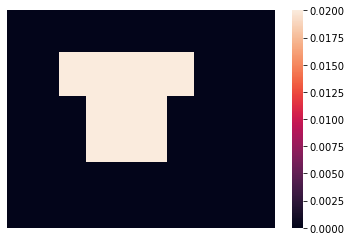

$u = \sin(x\pi)\sin(y\pi)$  
$f = \Delta u + (1+q) u = (1+q-2\pi^2)u$

In [5]:
def u_gen(N):
    u = np.zeros((N+1,N+1))
    for i in range(1,N):
        for j in range(1,N):
            u[i,j] = np.sin(i*np.pi/N)*np.sin(j*np.pi/N)
    return u

u_truth = u_gen(N)
sns.heatmap(u_truth, xticklabels=False, yticklabels=False)

<AxesSubplot:>

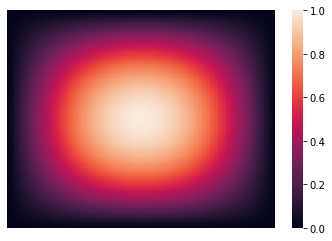

In [7]:
def f_gen_1(N,q,u):
    return (1+q-2*np.pi*np.pi)*u[1:-1,1:-1]

f = f_gen_1(N,q,u_truth)
sns.heatmap(f, xticklabels=False, yticklabels=False)

<AxesSubplot:>

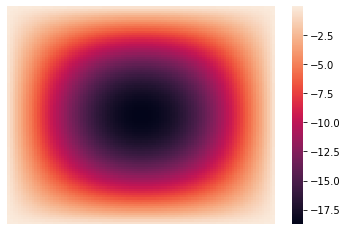

### 五点格式
$(u_{i+1,j} +u_{i-1,j} +u_{i,j+1} +u_{i,j-1} - 4u_{i,j})/h^2 + (1+q_{i,j})u_{i,j} = f_{i,j}$  
$A = \text{Tri}\,(T_1,T_1,T_2,\cdots,T_{N-1};I,I,\cdots,I;I,I,\cdots,I)$  
$T_{i} = \text{Tri}\,(1+q_{i,1}-\frac{4}{h^2},1+q_{i,2}-\frac{4}{h^2},\cdots,1+q_{i,n}-\frac{4}{h^2};\frac{1}{h^2},\frac{1}{h^2},\cdots,\frac{1}{h^2};\frac{1}{h^2},\frac{1}{h^2},\cdots,\frac{1}{h^2})$  
$U = (u_{1,1},u_{1,2},\ldots ,u_{n,n})^T$  
$F = (f_{1,1},f_{1,2},\ldots ,f_{n,n})^T$  
$AU = F$

In [9]:
def Gen_Matrix(N,q):
    M = N-1
    Q = q.reshape(M*M,1)
    row,col,data = np.array([]),np.array([]),np.array([])
    for i in range(M*M):
        row = np.append(row,i)
        col = np.append(col,i)
        data = np.append(data,1+Q[i] - 4*N*N)
        if (i+1)%M!=0:
            row = np.append(row,i)
            col = np.append(col,i+1)
            data = np.append(data,N*N)
        if (i+M)<M*M:
            row = np.append(row,i)
            col = np.append(col,i+M)
            data = np.append(data,N*N)
        if i%M!=0:
            row = np.append(row,i)
            col = np.append(col,i-1)
            data = np.append(data,N*N)
        if i-M > -1:
            row = np.append(row,i)
            col = np.append(col,i-M)
            data = np.append(data,N*N)
    return csc_matrix((data,(row,col)),shape = (M*M,M*M))

In [53]:
A = Gen_Matrix(N,q)
A1 = A.toarray()

In [54]:
A = Gen_Matrix(N,q)

# A_prom = Gen_Matrix(N,np.zeros(N-1,N-1))
F = f.reshape((N-1)*(N-1),1)

In [55]:
u_res,exit = gmres(A,F,tol = 1e-5,restart=100)
print(exit)

0


In [57]:
u_res = np.linalg.solve(A1,F)

<AxesSubplot:>

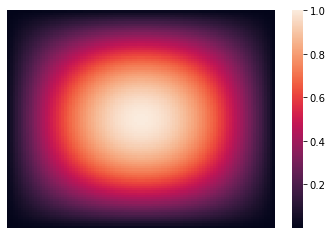

In [43]:
sns.heatmap(u, xticklabels=False, yticklabels=False)

In [44]:
err = np.abs(u-u_truth[1:-1,1:-1]).max()
print(err)

8.604358095354314e-05


|  用时   | N = 50  | N = 100| N = 150|
|  ----  | ----  | ----  |  ----  | 
| GMRES  | 0.355 | 6.14   | 51.2|
| 迭代法  | 0.726 | 6.06| 23.6  |

|  误差   | N = 50  | N = 100| N = 150|
|  ----  | ----  | ----  |  ----  | 
| GMRES  | 3.5e-4  | 8.5e-5    | 3.4e-5|
| 迭代法  | 3.5e-4 | 8.6e-5| 3.7e-5  |

* 直接求解稀疏方程组时，方程组阶数更高($N^2*N^2$) $\Rightarrow In[9]上方推导$ 用GMRES求解依然效率很低
* 迭代法求解时，N增大必须要到很高的迭代次数才能有较好的收敛性，例如N=150时需要迭代65536次
* 未来尝试将$q$全为0的矩阵，即Helmholtz对应的系数矩阵，作为近似$M$，来求解GMRES。
* 问题：上述这种矩阵的逆矩阵是否好求，已经可以求得其特征值

![111.jpg](111.jpg)